In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_validate
import mlflow
import mlflow.sklearn

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tqdm.auto import tqdm
import logging
import optuna

import warnings
warnings.filterwarnings("ignore")

In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [3]:
df = pd.read_csv("data/cleaned_v3_data.csv")

In [4]:
X = df.drop(['price'], axis=1)
Y = df['price']

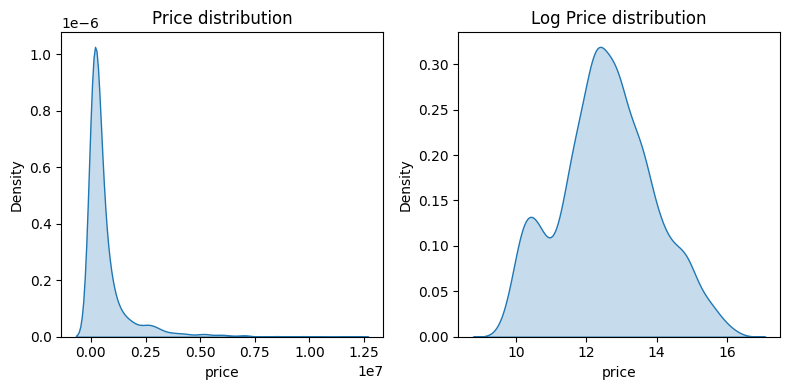

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(Y, ax=axes[0], fill='blue')
axes[0].set_title('Price distribution', fontsize=12)

sns.kdeplot(np.log(Y), ax=axes[1], fill='blue')
axes[1].set_title('Log Price distribution', fontsize=12)

plt.tight_layout()
plt.show()

In [6]:
Y_log = np.log1p(Y)

In [7]:
numerical_cols = ['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']
categorical_cols = X.drop(columns=['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']).columns.tolist()

binary_cat_cols = [
    col for col in categorical_cols
    if df[col].nunique() == 2
]
multi_cat_cols = df[categorical_cols].drop(columns=binary_cat_cols).columns

### Training a Base Model

In [80]:
mlflow.set_experiment("Base Model Label vs OneHot Encoding")

<Experiment: artifact_location='mlflow-artifacts:/727244903144796704', creation_time=1733126963002, experiment_id='727244903144796704', last_update_time=1733126963002, lifecycle_stage='active', name='Base Model Label vs OneHot Encoding', tags={}>

In [81]:
test_results = {}

In [82]:
X_processed = X.copy()

label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    X_processed[col] = label_encoders[col].fit_transform(X_processed[col])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test)  
    y_pred_orig = np.expm1(y_pred)  
    
    mlflow.log_param("encoding", "label encoding")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    test_results['model 1'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 660344467738.3046
RMSE: 812615.8180458368
MAE: 302905.3217895884
Model saved with MLflow
🏃 View run amazing-mouse-629 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/5b5e2591097f4e9fb8fd1a10ba00e8b8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


In [83]:
X_processed = X.copy()

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test)  
    y_pred_orig = np.expm1(y_pred)  
    
    mlflow.log_param("encoding", "one_hot encoding for all cat cols")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)
    
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    test_results['model 2'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 395423723191.8535
RMSE: 628827.2602168687
MAE: 197835.682947397
Model saved with MLflow
🏃 View run adorable-toad-912 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/5563785e41464cbf86cac0ac5eeae7a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


In [84]:
X_processed = X.copy()

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    y_test_orig = np.expm1(y_test) 
    y_pred_orig = np.expm1(y_pred)
    
    mlflow.log_param("encoding", "one_hot encoding for multi cat cols")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)

    test_results['model 3'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig
    }

    print("Model saved with MLflow")

MSE: 392211722447.81354
RMSE: 626268.0915133818
MAE: 196899.3744582893
Model saved with MLflow
🏃 View run exultant-crab-514 at: http://127.0.0.1:5000/#/experiments/727244903144796704/runs/a663c27c6e274774ba5c2393d7b324d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/727244903144796704


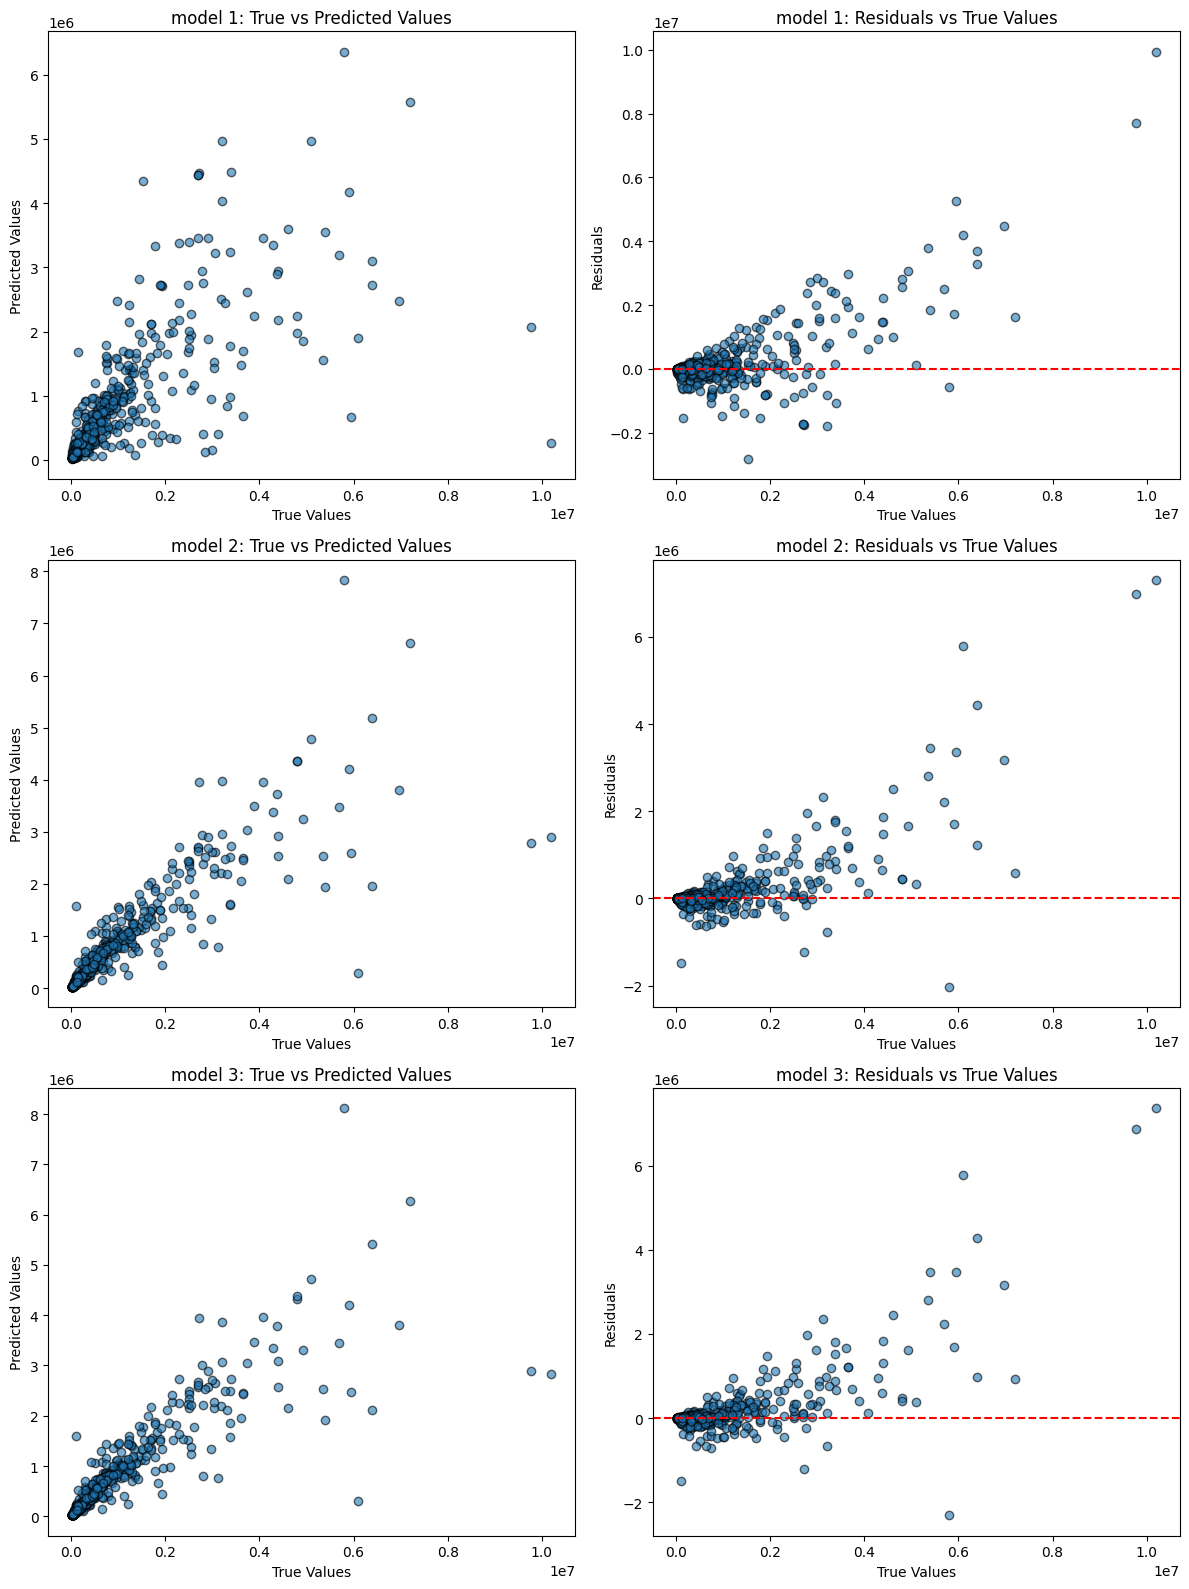

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

for i, model in enumerate(test_results.keys()):
    ytest = test_results[model]['y_test'].values
    ypred = test_results[model]['y_pred']
    
    residuals = ytest - ypred

    ax1 = axes[i, 0]
    ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"{model}: True vs Predicted Values")

    ax2 = axes[i, 1]
    ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()


We can clearly see that OneHot encoding for Multi-class columns shows the best results

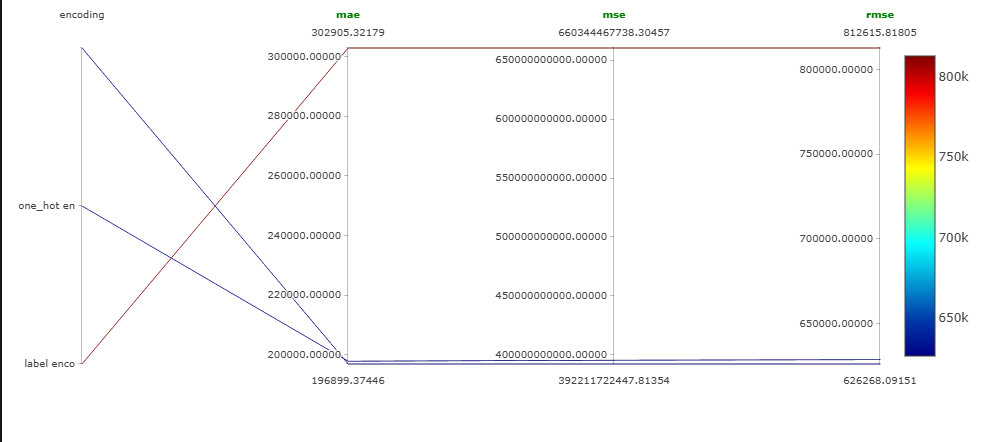

### Experiment 2: Selecting features

In [ ]:
# I have an assumption that luminosity columns don't contribute much to the performance of the model, lets check that

In [19]:
mlflow.set_experiment("Feature Selection")

<Experiment: artifact_location='mlflow-artifacts:/280729109587890328', creation_time=1733129005643, experiment_id='280729109587890328', last_update_time=1733129005643, lifecycle_stage='active', name='Feature Selection', tags={}>

In [20]:
test_results = {}

In [8]:
features = []
stones = []
luminosity = []
regular_col = []

for col in df.columns:
    if 'feature' in col:
        features.append(col)
    elif 'luminosity' in col:
        luminosity.append(col)
    elif 'precious_stone' in col:
        stones.append(col)
    else:
        regular_col.append(col)

In [23]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)

    y_test_orig = np.expm1(y_test) 
    y_pred_orig = np.expm1(y_pred)
    
    mlflow.log_param("name", "base")

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mse", mse)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    print("RMSE:", rmse)

    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mlflow.log_metric("mae", mae)
    print("MAE:", mae)
    
    train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
    mlflow.log_metric("train_mse", train_mse)
    print("train_mse:", train_mse)

    train_rmse = np.sqrt(train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    print("train_rmse:", train_rmse) 

    train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))
    mlflow.log_metric("train_mae", train_mae)
    print("train_mae:", train_mae)

    test_results[f'model base'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig,
    'y_train':  np.expm1(y_train),
    'y_train_pred': np.expm1(y_train_pred)
    }

    print("Model saved with MLflow")

MSE: 392211722447.81354
RMSE: 626268.0915133818
MAE: 196899.3744582893
train_mse: 77397473719.01324
train_rmse: 278204.0145630779
train_mae: 75482.0781892242
Model saved with MLflow
🏃 View run unique-shrike-818 at: http://127.0.0.1:5000/#/experiments/280729109587890328/runs/befd3fbb66514ee980a219637c03b0ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/280729109587890328


In [ ]:
for i, col_to_drop in enumerate([luminosity, features, stones]):
    
    X_processed = X.drop(columns=col_to_drop)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]
    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

    X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    if i == 0:
        name = "lum"
    elif i == 1:
        name = "feat"
    else:
        name = "stones"

    with mlflow.start_run(run_name=f"no {name}"):
        
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_train_pred = pipeline.predict(X_train)

        y_test_orig = np.expm1(y_test) 
        y_pred_orig = np.expm1(y_pred)

        mlflow.log_param("name", name)

        mse = mean_squared_error(y_test_orig, y_pred_orig)
        mlflow.log_metric("mse", mse)
        print("MSE:", mse)

        rmse = np.sqrt(mse)
        mlflow.log_metric("rmse", rmse)
        print("RMSE:", rmse)

        mae = mean_absolute_error(y_test_orig, y_pred_orig)
        mlflow.log_metric("mae", mae)
        print("MAE:", mae)
        
        train_mse = mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))
        mlflow.log_metric("train_mse", train_mse)
        print("train_mse:", train_mse)
        
        train_rmse = np.sqrt(train_mse)
        mlflow.log_metric("train_rmse", train_rmse)
        print("train_rmse:", train_rmse) 
        
        train_mae = mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred))
        mlflow.log_metric("train_mae", train_mae)
        print("train_mae:", train_mae)
        
        test_results[f'model {name}'] = {
        'y_test': y_test_orig,
        'y_pred': y_pred_orig,
        'y_train':  np.expm1(y_train),
        'y_train_pred': np.expm1(y_train_pred)
        }

        print("Model saved with MLflow")

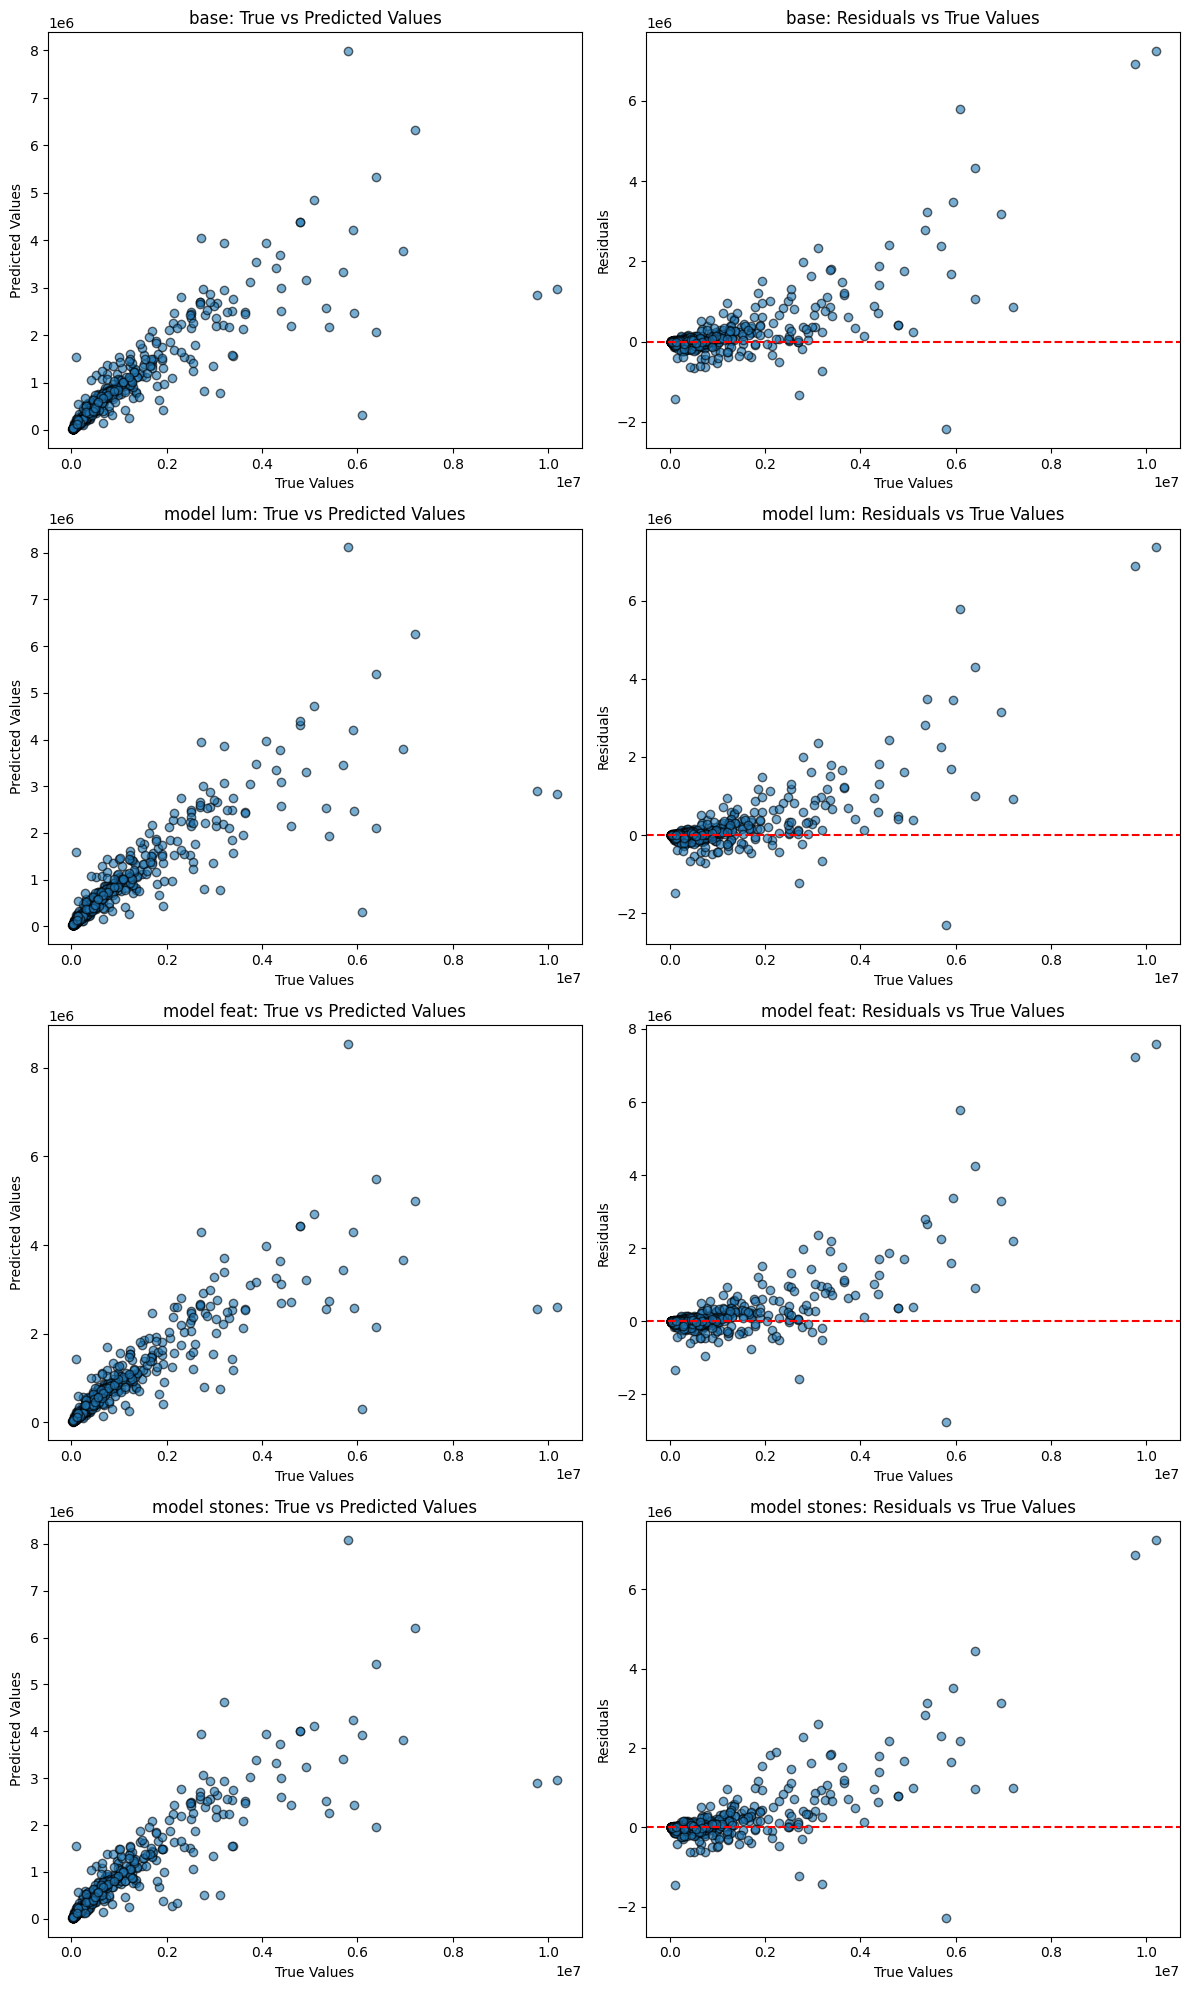

In [111]:
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, model in enumerate(['base','model lum', 'model feat','model stones']):
    ytest = test_results[model]['y_test'].values
    ypred = test_results[model]['y_pred']
    
    residuals = ytest - ypred

    ax1 = axes[i, 0]
    ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"{model}: True vs Predicted Values")

    ax2 = axes[i, 1]
    ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()


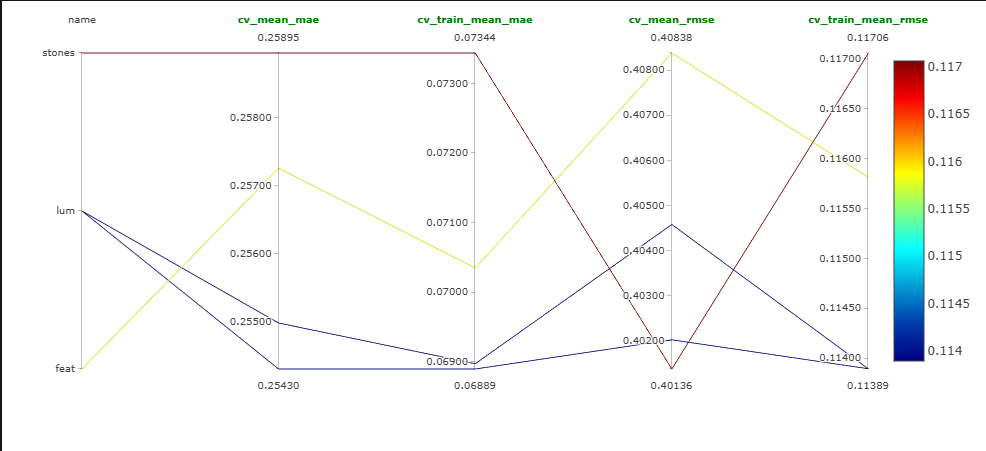

In [29]:
## Cross validation

In [26]:
mlflow.set_experiment("CV features")

2024/12/02 17:02:12 INFO mlflow.tracking.fluent: Experiment with name 'CV features' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/202848682694580044', creation_time=1733139132819, experiment_id='202848682694580044', last_update_time=1733139132819, lifecycle_stage='active', name='CV features', tags={}>

In [27]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

with mlflow.start_run():
    cv_results = cross_validate(
        pipeline, X_processed, Y_log, 
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
        cv=5, return_train_score=True
    )

    mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
    mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
    mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()

    mlflow.log_param("name", "base")
    mlflow.log_metric("cv_mean_mse", mean_mse)
    mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
    mlflow.log_metric("cv_mean_mae", mean_mae)
    mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
    mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
    mlflow.log_metric("cv_train_mean_mae", mean_train_mae)

    print(f"Model base:")
    print("CV Mean MSE:", mean_mse)
    print("CV Mean RMSE:", np.sqrt(mean_mse))
    print("CV Mean MAE:", mean_mae)
    print("CV Train Mean MSE:", mean_train_mse)
    print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
    print("CV Train Mean MAE:", mean_train_mae)

Model lum:
CV Mean MSE: 0.16161366642856573
CV Mean RMSE: 0.4020120227413177
CV Mean MAE: 0.25430129914172284
CV Train Mean MSE: 0.012971698870454459
CV Train Mean RMSE: 0.11389336622672305
CV Train Mean MAE: 0.06889401346925612
🏃 View run abrasive-toad-496 at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/f28644c824f24715b64b2134c676e826
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044


In [28]:
from sklearn.model_selection import cross_validate

for i, col_to_drop in enumerate([luminosity, features, stones]):
    X_processed = X.drop(columns=col_to_drop)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]
    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ]
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    if i == 0:
        name = "lum"
    elif i == 1:
        name = "feat"
    else:
        name = "stones"

    with mlflow.start_run(run_name=f"no {name}"):
        cv_results = cross_validate(
            pipeline, X_processed, Y_log, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
            cv=5, return_train_score=True
        )

        mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
        mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
        mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
        mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()

        mlflow.log_param("name", name)
        mlflow.log_metric("cv_mean_mse", mean_mse)
        mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
        mlflow.log_metric("cv_mean_mae", mean_mae)
        mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
        mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
        mlflow.log_metric("cv_train_mean_mae", mean_train_mae)

        print(f"Model {name}:")
        print("CV Mean MSE:", mean_mse)
        print("CV Mean RMSE:", np.sqrt(mean_mse))
        print("CV Mean MAE:", mean_mae)
        print("CV Train Mean MSE:", mean_train_mse)
        print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
        print("CV Train Mean MAE:", mean_train_mae)

Model lum:
CV Mean MSE: 0.16368036834155225
CV Mean RMSE: 0.40457430509308456
CV Mean MAE: 0.2549778325678237
CV Train Mean MSE: 0.012971154416057359
CV Train Mean RMSE: 0.1138909760080111
CV Train Mean MAE: 0.06897009095701354
🏃 View run no lum at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/019be667538d42bc923739c4050f9315
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044
Model feat:
CV Mean MSE: 0.16677725462430334
CV Mean RMSE: 0.4083837100378801
CV Mean MAE: 0.25725688023653265
CV Train Mean MSE: 0.013412910422018592
CV Train Mean RMSE: 0.11581412013229904
CV Train Mean MAE: 0.07034589431307203
🏃 View run no feat at: http://127.0.0.1:5000/#/experiments/202848682694580044/runs/13fecf6bd69c47c7bd6af21d44a7a2ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202848682694580044
Model stones:
CV Mean MSE: 0.1610926229197423
CV Mean RMSE: 0.4013634548881379
CV Mean MAE: 0.2589520791167813
CV Train Mean MSE: 0.013702852984483252
CV Tra

### Model Selection

In [62]:
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
#             'regressor__fit_intercept': [True, False],
#             'regressor__positive': [False, True]
        }
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
#             'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
#             'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
#             'regressor__fit_intercept': [True, False],
#             'regressor__positive': [False, True]
        }
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {
#             'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
#             'regressor__selection': ['cyclic', 'random'],
#             'regressor__fit_intercept': [True, False],
#             'regressor__positive': [False, True]
        }
    },

    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params':
        {
#             'regressor__n_estimators': [200, 300, 500],
#             'regressor__learning_rate': [0.01, 0.1],
#             'regressor__max_depth': [3, 5, 7],
#             'regressor__subsample': [0.8, 0.9, 1.0],
        }
    },
    'SVR': {
        'model': SVR(),
        'params': 
        {
#             'regressor__kernel': ['rbf', 'linear', 'poly'],
#             'regressor__C': [0.1, 1],
#             'regressor__epsilon': [0.1, 0.2],
#             'regressor__gamma': ['scale', 'auto', 0.1, 1],
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
#             'regressor__max_depth': [None, 10, 20, 30, 50],
#             'regressor__min_samples_split': [2, 5, 10, 15],
#             'regressor__min_samples_leaf': [1, 2, 4],
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
#             'regressor__n_estimators': [100, 300, 500, 1000, 1500],
#             'regressor__learning_rate': [0.01, 0.1, 0.3],
#             'regressor__max_depth': [3, 5, 7, 10],
#             'regressor__min_child_weight': [1, 3, 5],
#             'regressor__subsample': [0.6, 0.8, 1.0],
#             'regressor__colsample_bytree': [0.6, 0.8, 1.0],
#             'regressor__gamma': [0, 0.1, 0.3],
#             'regressor__reg_alpha': [0, 0.1, 1],
#             'regressor__reg_lambda': [0, 0.1, 1]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=0),
        'params': {
#             'regressor__iterations': [100, 500, 1000, 1500, 3000],
#             'regressor__learning_rate': [0.01, 0.1, 0.3],
#             'regressor__depth': [4, 6, 8, 10],
#             'regressor__l2_leaf_reg': [1, 3, 5, 10],
#             'regressor__rsm': [0.6, 0.8, 1.0],
#             'regressor__random_strength': [0, 0.1, 1],
#             'regressor__bagging_temperature': [0, 1],
#             'regressor__border_count': [32, 64, 128],
#             'regressor__loss_function': ['RMSE', 'MAE', 'MAPE']
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
#             'regressor__n_estimators': [100, 500, 1000, 1500, 3000],
#             'regressor__learning_rate': [0.01, 0.1, 0.3],
#             'regressor__max_depth': [3, 5, 7, -1],
#             'regressor__num_leaves': [31, 50, 70, 100],
#             'regressor__min_child_samples': [20, 50, 100],
#             'regressor__subsample': [0.6, 0.8, 1.0],
#             'regressor__colsample_bytree': [0.6, 0.8, 1.0],
#             'regressor__reg_alpha': [0, 0.1, 1],
#             'regressor__reg_lambda': [0, 0.1, 1],
#             'regressor__min_split_gain': [0, 0.1, 0.3],
#             'regressor__boosting_type': ['gbdt', 'dart', 'goss']
        }
    },
    
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
#             'regressor__n_estimators': [100, 200, 500],
#             'regressor__max_depth': [None, 10, 20, 30],
#             'regressor__min_samples_split': [2, 5, 10, 15],
#             'regressor__min_samples_leaf': [1, 2, 4],
#             'regressor__max_features': ['auto', 'sqrt', 'log2'],
#             'regressor__bootstrap': [True, False],
#             'regressor__criterion': ['squared_error', 'absolute_error']
        }
    },
}


In [63]:
mlflow.set_experiment("Model Selection")

<Experiment: artifact_location='mlflow-artifacts:/101523853129733287', creation_time=1733142809418, experiment_id='101523853129733287', last_update_time=1733142809418, lifecycle_stage='active', name='Model Selection', tags={}>

In [64]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]

multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

cat_indices = []
cat_feature_mask = X_processed.columns.isin(categorical_cols)
cat_indices = list(np.where(cat_feature_mask)[0])

results = {}

for model_name, model_info in models.items():

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model_info['model'])
    ])

    with mlflow.start_run(run_name=f"experiment_{model_name}"):
        
        print(f"Performing run for model_{model_name}")
        cv_results = cross_validate(
            pipeline, X_processed, Y_log, 
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
            cv=5, return_train_score=True
        )

        mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
        mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
        mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
        mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()

        mlflow.log_param("model", model_name)
        mlflow.log_metric("cv_mean_mse", mean_mse)
        mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
        mlflow.log_metric("cv_mean_mae", mean_mae)
        mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
        mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
        mlflow.log_metric("cv_train_mean_mae", mean_train_mae)

        print(f"Model: {model_name}")
        print("CV Mean MSE:", mean_mse)
        print("CV Mean RMSE:", np.sqrt(mean_mse))
        print("CV Mean MAE:", mean_mae)
        print("CV Train Mean MSE:", mean_train_mse)
        print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
        print("CV Train Mean MAE:", mean_train_mae)
        print("-" * 50)

Performing run for model_Gradient Boosting
Model: Gradient Boosting
CV Mean MSE: 0.23617365163552892
CV Mean RMSE: 0.4859770073115897
CV Mean MAE: 0.3671051821588195
CV Train Mean MSE: 0.14975337066319436
CV Train Mean RMSE: 0.38697980653154807
CV Train Mean MAE: 0.3009325075079726
--------------------------------------------------
🏃 View run experiment_Gradient Boosting at: http://127.0.0.1:5000/#/experiments/101523853129733287/runs/a8ba120a8d2144e4b8812ad7c211d15b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/101523853129733287
Performing run for model_SVR
Model: SVR
CV Mean MSE: 0.15038654960297088
CV Mean RMSE: 0.3877970469239946
CV Mean MAE: 0.26737233746842526
CV Train Mean MSE: 0.04757841325951312
CV Train Mean RMSE: 0.21812476535119327
CV Train Mean MAE: 0.14470246967500194
--------------------------------------------------
🏃 View run experiment_SVR at: http://127.0.0.1:5000/#/experiments/101523853129733287/runs/9079af7bc616419190632fb7edf2e426
🧪 View experiment at:

  File "C:\Users\Admin\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Admin\anaconda3\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Admin\anaconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Admin\anaconda3\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 909
[LightGBM] [Info] Number of data points in the train set: 3636, number of used features: 125
[LightGBM] [Info] Start training from score 12.575186
Performing run for model_LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 2908, number of used features: 115
[LightGBM] [Info] Start training from score 12.589090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002805 seconds.
You can set `force_row_wise=true` to remove the ov

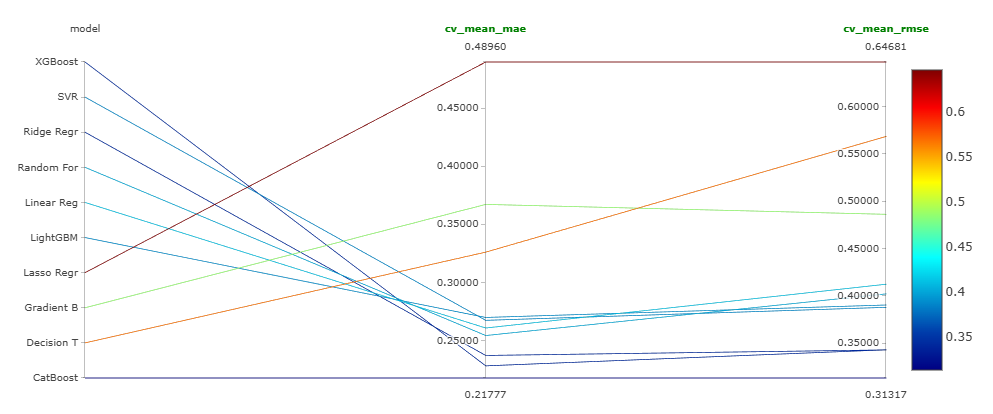

CatBoost, Xgboost and Ridge regression perform the best. Need to do hypermater tuning on these models to choose the best one.

In [8]:
mlflow.set_experiment("Hyperparameter tuning")

2024/12/03 12:31:30 INFO mlflow.tracking.fluent: Experiment with name 'Hyperparameter tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/113014624842399351', creation_time=1733209290023, experiment_id='113014624842399351', last_update_time=1733209290023, lifecycle_stage='active', name='Hyperparameter tuning', tags={}>

In [39]:
models = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
            'regressor__fit_intercept': [True, False],
            'regressor__positive': [False, True]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [500, 1000, 1500],
            'regressor__learning_rate': [0.01, 0.1, 0.3],
            'regressor__max_depth': [3, 5, 7, 10],
            'regressor__min_child_weight': [1, 3, 5],
            'regressor__subsample': [0.6, 0.8, 1.0],
            'regressor__colsample_bytree': [0.6, 0.8, 1.0],
            'regressor__gamma': [0, 0.1, 0.3],
            'regressor__reg_alpha': [0, 0.1, 1],
            'regressor__reg_lambda': [0, 0.1, 1]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=0),
        'params': {
            'regressor__iterations': [500, 1000, 1500, 3000],
            'regressor__learning_rate': [0.01, 0.1, 0.3],
            'regressor__depth': [4, 6, 8, 10],
            'regressor__l2_leaf_reg': [1, 3, 5, 10],
            'regressor__rsm': [0.8, 1.0],
            'regressor__random_strength': [0, 0.1, 1],
            'regressor__bagging_temperature': [0, 1],
            'regressor__border_count': [32, 64, 128],
            'regressor__loss_function': ['RMSE', 'MAE']
        }
    },
}

In [45]:
def objective(trial, X, Y_log, preprocessor, model_name, total_trials):
    if hasattr(objective, 'progress_bar'):
        objective.progress_bar.update(1)
        objective.progress_bar.set_description(f"Running {model_name} - Trial {trial.number}")
   
    if model_name == 'Ridge':
        alpha = trial.suggest_loguniform('regressor__alpha', 0.01, 100.0)
        solver = trial.suggest_categorical('regressor__solver', ['auto', 'cholesky', 'lsqr'])
        fit_intercept = trial.suggest_categorical('regressor__fit_intercept', [True, False])
        positive = trial.suggest_categorical('regressor__positive', [False, True])
        
        model = Ridge(
            alpha=alpha, 
            solver=solver, 
            fit_intercept=fit_intercept, 
#             positive=positive
        )
    
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_categorical('regressor__n_estimators', [500, 1000, 1500])
        learning_rate = trial.suggest_loguniform('regressor__learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('regressor__max_depth', 3, 10)
        min_child_weight = trial.suggest_int('regressor__min_child_weight', 1, 5)
        subsample = trial.suggest_uniform('regressor__subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_uniform('regressor__colsample_bytree', 0.6, 1.0)
        gamma = trial.suggest_loguniform('regressor__gamma', 1e-8, 1.0)
        reg_alpha = trial.suggest_loguniform('regressor__reg_alpha', 1e-8, 1.0)
        reg_lambda = trial.suggest_loguniform('regressor__reg_lambda', 1e-8, 1.0)
        
        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42
        )
    
    elif model_name == 'CatBoost':
        iterations = trial.suggest_categorical('regressor__iterations', [500, 1000, 1500, 3000])
        learning_rate = trial.suggest_loguniform('regressor__learning_rate', 0.01, 0.3)
        depth = trial.suggest_int('regressor__depth', 4, 10)
        l2_leaf_reg = trial.suggest_int('regressor__l2_leaf_reg', 1, 10)
        rsm = trial.suggest_uniform('regressor__rsm', 0.8, 1.0)
        random_strength = trial.suggest_loguniform('regressor__random_strength', 1e-8, 1.0)
        bagging_temperature = trial.suggest_uniform('regressor__bagging_temperature', 0, 1)
        border_count = trial.suggest_categorical('regressor__border_count', [32, 64, 128])
        loss_function = trial.suggest_categorical('regressor__loss_function', ['RMSE', 'MAE'])
        
        model = CatBoostRegressor(
            iterations=iterations,
            learning_rate=learning_rate,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            rsm=rsm,
            random_strength=random_strength,
            bagging_temperature=bagging_temperature,
            border_count=border_count,
            loss_function=loss_function,
            random_state=42,
            thread_count=-1,
            verbose=0
        )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    cv_results = cross_validate(
        pipeline, X, Y_log, 
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
        cv=3, return_train_score=True
    )
    return -cv_results['test_neg_mean_squared_error'].mean()

def run_optuna_optimization(X_processed, Y_log, preprocessor, models, n_trials=50):
    
    optuna.logging.enable_default_handler()
    optuna.logging.enable_propagation()
    optuna.logging.set_verbosity(optuna.logging.INFO)
    
    results = {}
    
    total_trials = n_trials * len(models)
    
    global_progress_bar = tqdm(total=total_trials, desc="Optuna Hyperparameter Optimization", 
                                position=0, leave=True)
    
    objective.progress_bar = global_progress_bar    
    
    for model_name, model_info in models.items():
        study = optuna.create_study(direction='minimize', 
                                    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5))
        
        objective_with_args = lambda trial: objective(trial, X_processed, Y_log, preprocessor, model_name, total_trials)
        
        print(f"Running Optuna optimization for {model_name}")
        
        trial_results = []
        
        def log_trial_result(study, trial):
            if trial.state == optuna.trial.TrialState.COMPLETE:
                trial_results.append({
                    'number': trial.number,
                    'value': trial.value,
                    'params': trial.params
                })
                logging.info(
                    f"Model: {model_name}, "
                    f"Trial {trial.number}, "
                    f"Value: {trial.value}, "
                    f"Params: {trial.params}"
                )

        
        print(f"Running Optuna optimization for {model_name}")
        study.optimize(
            objective_with_args, 
            n_trials=n_trials,
            callbacks=[log_trial_result]
        )
        
        with mlflow.start_run(run_name=f"optuna_experiment_{model_name}"):
            
            mlflow.log_param("total_trials", study.trials_dataframe().shape[0])
            mlflow.log_param("completed_trials", 
                len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]))
            mlflow.log_param("pruned_trials", 
                len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]))
            
            # Log the best trial information
            best_trial = study.best_trial
            mlflow.log_metric("best_trial_value", best_trial.value)
            mlflow.log_param("best_trial_number", best_trial.number)
       
            best_params = study.best_params
            
            for param, value in best_params.items():
                mlflow.log_param(param, value)
            
            if model_name == 'Ridge':
                best_model = Ridge(
                    alpha=best_params.get('regressor__alpha', 1.0),
                    solver=best_params.get('regressor__solver', 'auto'),
                    fit_intercept=best_params.get('regressor__fit_intercept', True),
                )
            elif model_name == 'XGBoost':
                best_model = XGBRegressor(
                    n_estimators=best_params.get('regressor__n_estimators', 1000),
                    learning_rate=best_params.get('regressor__learning_rate', 0.1),
                    max_depth=best_params.get('regressor__max_depth', 5),
                    min_child_weight=best_params.get('regressor__min_child_weight', 1),
                    subsample=best_params.get('regressor__subsample', 0.8),
                    colsample_bytree=best_params.get('regressor__colsample_bytree', 0.8),
                    gamma=best_params.get('regressor__gamma', 0),
                    reg_alpha=best_params.get('regressor__reg_alpha', 0),
                    reg_lambda=best_params.get('regressor__reg_lambda', 0),
                    random_state=42
                )
            elif model_name == 'CatBoost':
                best_model = CatBoostRegressor(
                    iterations=best_params.get('regressor__iterations', 1000),
                    learning_rate=best_params.get('regressor__learning_rate', 0.1),
                    depth=best_params.get('regressor__depth', 6),
                    l2_leaf_reg=best_params.get('regressor__l2_leaf_reg', 3),
                    rsm=best_params.get('regressor__rsm', 1.0),
                    random_strength=best_params.get('regressor__random_strength', 0),
                    bagging_temperature=best_params.get('regressor__bagging_temperature', 0),
                    border_count=best_params.get('regressor__border_count', 64),
                    loss_function=best_params.get('regressor__loss_function', 'RMSE'),
                    random_state=42,
                    verbose=0
                )
            
            final_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', best_model)
            ])
            
            cv_results = cross_validate(
                final_pipeline, X_processed, Y_log, 
                scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                cv=3, return_train_score=True
            )
            
            mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
            mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
            mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
            mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()
            
            mlflow.log_metric("cv_mean_mse", mean_mse)
            mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
            mlflow.log_metric("cv_mean_mae", mean_mae)
            mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
            mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
            mlflow.log_metric("cv_train_mean_mae", mean_train_mae)
            
            print(f"Model: {model_name}")
            print("CV Mean MSE:", mean_mse)
            print("CV Mean RMSE:", np.sqrt(mean_mse))
            print("CV Mean MAE:", mean_mae)
            print("CV Train Mean MSE:", mean_train_mse)
            print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
            print("CV Train Mean MAE:", mean_train_mae)
            print("Best Parameters:", best_params)
            print("-" * 50)
            
    global_progress_bar.close()
    
    return results

In [46]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]

multi_cat_cols = X_processed[categorical_cols].drop(columns=binary_cat_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

results = run_optuna_optimization(
    X_processed, 
    Y_log, 
    preprocessor, 
    models, 
    n_trials=50
)

Optuna Hyperparameter Optimization:   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-03 13:36:46,307] A new study created in memory with name: no-name-84d214dc-19ca-4921-94e5-1e78fc05259a
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-84d214dc-19ca-4921-94e5-1e78fc05259a


Running Optuna optimization for CatBoost
Running Optuna optimization for CatBoost


[I 2024-12-03 13:37:25,898] Trial 0 finished with value: 0.12675619632202648 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.020218087861629028, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 10, 'regressor__rsm': 0.8266605656446477, 'regressor__random_strength': 0.0001766010922917345, 'regressor__bagging_temperature': 0.37840512174128416, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 0 with value: 0.12675619632202648.
INFO:optuna.study.study:Trial 0 finished with value: 0.12675619632202648 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.020218087861629028, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 10, 'regressor__rsm': 0.8266605656446477, 'regressor__random_strength': 0.0001766010922917345, 'regressor__bagging_temperature': 0.37840512174128416, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 0 with value: 0.12675619632202648.
[I 2024-12-03 13:37:32

INFO:optuna.study.study:Trial 8 finished with value: 0.20985131349209754 and parameters: {'regressor__iterations': 500, 'regressor__learning_rate': 0.01819000227057532, 'regressor__depth': 8, 'regressor__l2_leaf_reg': 10, 'regressor__rsm': 0.8936275161929174, 'regressor__random_strength': 0.00013043562252544613, 'regressor__bagging_temperature': 0.0833394230758342, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 0 with value: 0.12675619632202648.
[I 2024-12-03 13:47:01,110] Trial 9 finished with value: 0.16966996615350352 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.09305564440998843, 'regressor__depth': 9, 'regressor__l2_leaf_reg': 1, 'regressor__rsm': 0.8474871499333929, 'regressor__random_strength': 8.421115995256615e-07, 'regressor__bagging_temperature': 0.5260350106807323, 'regressor__border_count': 64, 'regressor__loss_function': 'MAE'}. Best is trial 0 with value: 0.12675619632202648.
INFO:optuna.study.study:Tria

[I 2024-12-03 13:53:03,857] Trial 17 finished with value: 0.11392985421877512 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.29106768590097054, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 5, 'regressor__rsm': 0.8633250243075604, 'regressor__random_strength': 0.0007670900524349717, 'regressor__bagging_temperature': 0.7758094320860631, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 16 with value: 0.10859340242251903.
INFO:optuna.study.study:Trial 17 finished with value: 0.11392985421877512 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.29106768590097054, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 5, 'regressor__rsm': 0.8633250243075604, 'regressor__random_strength': 0.0007670900524349717, 'regressor__bagging_temperature': 0.7758094320860631, 'regressor__border_count': 128, 'regressor__loss_function': 'RMSE'}. Best is trial 16 with value: 0.10859340242251903.
[I 2024-12-03 13:53:19

INFO:optuna.study.study:Trial 25 finished with value: 0.11088941580521915 and parameters: {'regressor__iterations': 1500, 'regressor__learning_rate': 0.11943933476465136, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 8, 'regressor__rsm': 0.8451921231695575, 'regressor__random_strength': 1.5666222800490565e-07, 'regressor__bagging_temperature': 0.7546812959692885, 'regressor__border_count': 32, 'regressor__loss_function': 'RMSE'}. Best is trial 24 with value: 0.10395790735787609.
[I 2024-12-03 13:55:42,144] Trial 26 finished with value: 0.13281798226016678 and parameters: {'regressor__iterations': 1500, 'regressor__learning_rate': 0.20015624762416553, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 8, 'regressor__rsm': 0.8503342962653739, 'regressor__random_strength': 4.9586523042351264e-06, 'regressor__bagging_temperature': 0.6111031483055425, 'regressor__border_count': 32, 'regressor__loss_function': 'MAE'}. Best is trial 24 with value: 0.10395790735787609.
INFO:optuna.study.study

[I 2024-12-03 13:59:17,414] Trial 34 finished with value: 0.14322195315259625 and parameters: {'regressor__iterations': 1500, 'regressor__learning_rate': 0.2518187104244315, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 7, 'regressor__rsm': 0.81916338666875, 'regressor__random_strength': 7.354005506058249e-06, 'regressor__bagging_temperature': 0.9156263517544992, 'regressor__border_count': 32, 'regressor__loss_function': 'MAE'}. Best is trial 24 with value: 0.10395790735787609.
INFO:optuna.study.study:Trial 34 finished with value: 0.14322195315259625 and parameters: {'regressor__iterations': 1500, 'regressor__learning_rate': 0.2518187104244315, 'regressor__depth': 5, 'regressor__l2_leaf_reg': 7, 'regressor__rsm': 0.81916338666875, 'regressor__random_strength': 7.354005506058249e-06, 'regressor__bagging_temperature': 0.9156263517544992, 'regressor__border_count': 32, 'regressor__loss_function': 'MAE'}. Best is trial 24 with value: 0.10395790735787609.
[I 2024-12-03 13:59:51,635] Tria

INFO:optuna.study.study:Trial 42 finished with value: 0.10469491222750793 and parameters: {'regressor__iterations': 3000, 'regressor__learning_rate': 0.2395643602211153, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 4, 'regressor__rsm': 0.8654934166522222, 'regressor__random_strength': 0.0021987594607306635, 'regressor__bagging_temperature': 0.7481236304674773, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 24 with value: 0.10395790735787609.
[I 2024-12-03 14:02:43,162] Trial 43 finished with value: 0.10794672308280578 and parameters: {'regressor__iterations': 1500, 'regressor__learning_rate': 0.24445841221934297, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 2, 'regressor__rsm': 0.892972452434032, 'regressor__random_strength': 1.1339610005006764e-05, 'regressor__bagging_temperature': 0.7482372749116604, 'regressor__border_count': 64, 'regressor__loss_function': 'RMSE'}. Best is trial 24 with value: 0.10395790735787609.
INFO:optuna.study.study:T

Model: CatBoost
CV Mean MSE: 0.10395790735787609
CV Mean RMSE: 0.3224250414559578
CV Mean MAE: 0.2165431953057112
CV Train Mean MSE: 0.010299017930662803
CV Train Mean RMSE: 0.10148407722723207
CV Train Mean MAE: 0.07512653316655193
Best Parameters: {'regressor__iterations': 1500, 'regressor__learning_rate': 0.21851510473670352, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 8, 'regressor__rsm': 0.8488982802701295, 'regressor__random_strength': 2.138020781242421e-05, 'regressor__bagging_temperature': 0.860825280116421, 'regressor__border_count': 32, 'regressor__loss_function': 'RMSE'}
--------------------------------------------------
🏃 View run optuna_experiment_CatBoost at: http://127.0.0.1:5000/#/experiments/113014624842399351/runs/1ed29b9b062d463cbef9add98d0b8146
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/113014624842399351


Through experimentations, we found that the CatBoost performs the best even adter hyperparameter tuning

In [47]:
mlflow.set_experiment("Manual Tuning")

2024/12/03 14:32:34 INFO mlflow.tracking.fluent: Experiment with name 'Manual Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/487140566403542757', creation_time=1733216554797, experiment_id='487140566403542757', last_update_time=1733216554797, lifecycle_stage='active', name='Manual Tuning', tags={}>

In [56]:
# Manually tweaking some parameters as I didn't got the best values from the optuna(low number of trials)

with mlflow.start_run():

    model_name = 'CatBoost'

    params = {
        'iterations': 1500,
        'learning_rate': 0.21851510473670352,
        'depth': 4,
        'l2_leaf_reg': 8,
        'rsm': 0.8488982802701295,
        'random_strength': 2.138020781242421e-05,
        'bagging_temperature': 0.00060825280116421,
        'border_count': 8,
        'verbose':0,
        'loss_function': 'RMSE'
    }

    model = CatBoostRegressor(**params)

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    cv_results = cross_validate(
        final_pipeline, X_processed, Y_log, 
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
        cv=5, return_train_score=True
    )

    mlflow.log_param('model', model_name+"7")
    mlflow.log_params(params)

    mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
    mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
    mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()

    mlflow.log_metric("cv_mean_mse", mean_mse)
    mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
    mlflow.log_metric("cv_mean_mae", mean_mae)
    mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
    mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
    mlflow.log_metric("cv_train_mean_mae", mean_train_mae)

    print(f"Model: {model_name}")
    print("CV Mean MSE:", mean_mse)
    print("CV Mean RMSE:", np.sqrt(mean_mse))
    print("CV Mean MAE:", mean_mae)
    print("CV Train Mean MSE:", mean_train_mse)
    print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
    print("CV Train Mean MAE:", mean_train_mae)
    print("-" * 50)

Model: CatBoost
CV Mean MSE: 0.07756081383087014
CV Mean RMSE: 0.27849742158747204
CV Mean MAE: 0.18971517932006438
CV Train Mean MSE: 0.012814366466255242
CV Train Mean RMSE: 0.11320055859515553
CV Train Mean MAE: 0.08369481863654385
--------------------------------------------------
🏃 View run handsome-stoat-508 at: http://127.0.0.1:5000/#/experiments/487140566403542757/runs/8087934522fc4890b94d6f7b053d13bb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/487140566403542757


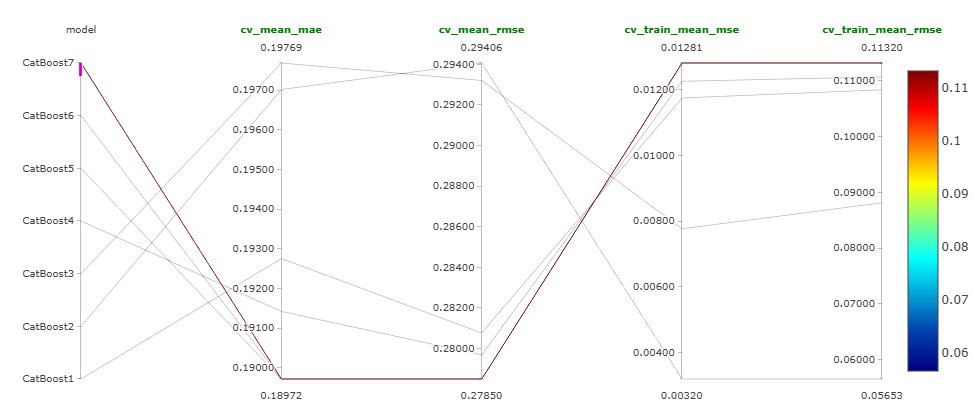

In [9]:
experiment_name = "Manual Tuning"
experiment = mlflow.get_experiment_by_name(experiment_name)

runs = mlflow.search_runs(experiment_ids=experiment.experiment_id, 
                          filter_string='', 
                          run_view_type=mlflow.entities.ViewType.ALL)
best_run = runs.loc[runs['metrics.cv_mean_mse'].idxmin()]

In [10]:
params = {
        'iterations': int(best_run.loc['params.iterations']),
        'learning_rate': float(best_run.loc['params.learning_rate']),
        'depth': int(best_run.loc['params.depth']),
        'l2_leaf_reg': int(best_run.loc['params.l2_leaf_reg']),
        'rsm': float(best_run.loc['params.rsm']),
        'random_strength': float(best_run.loc['params.random_strength']),
        'bagging_temperature': float(best_run.loc['params.bagging_temperature']),
        'border_count': int(best_run.loc['params.border_count']),
        'verbose':0,
        'loss_function': best_run.loc['params.loss_function']
    }

In [74]:
mlflow.set_experiment("Checking feature imp")

2024/12/03 14:58:33 INFO mlflow.tracking.fluent: Experiment with name 'Checking feature imp' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/730294856138610483', creation_time=1733218113613, experiment_id='730294856138610483', last_update_time=1733218113613, lifecycle_stage='active', name='Checking feature imp', tags={}>

In [79]:
with mlflow.start_run():
    
    X_processed = X.drop(columns=luminosity)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]
    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

    model_name = 'CatBoost'

    model = CatBoostRegressor(**params)

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    cv_results = cross_validate(
        final_pipeline, X_processed, Y_log, 
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
        cv=5, return_train_score=True
    )

    mlflow.log_param('model', model_name+"_no_lum")
    
    mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
    mean_train_mse = -cv_results['train_neg_mean_squared_error'].mean()
    mean_train_mae = -cv_results['train_neg_mean_absolute_error'].mean()

    mlflow.log_metric("cv_mean_mse", mean_mse)
    mlflow.log_metric("cv_mean_rmse", np.sqrt(mean_mse))
    mlflow.log_metric("cv_mean_mae", mean_mae)
    mlflow.log_metric("cv_train_mean_mse", mean_train_mse)
    mlflow.log_metric("cv_train_mean_rmse", np.sqrt(mean_train_mse))
    mlflow.log_metric("cv_train_mean_mae", mean_train_mae)

    print(f"Model: {model_name}")
    print("CV Mean MSE:", mean_mse)
    print("CV Mean RMSE:", np.sqrt(mean_mse))
    print("CV Mean MAE:", mean_mae)
    print("CV Train Mean MSE:", mean_train_mse)
    print("CV Train Mean RMSE:", np.sqrt(mean_train_mse))
    print("CV Train Mean MAE:", mean_train_mae)
    print("-" * 50)

Model: CatBoost
CV Mean MSE: 0.07507735740197374
CV Mean RMSE: 0.27400247699970476
CV Mean MAE: 0.19001965002314544
CV Train Mean MSE: 0.013190833571500643
CV Train Mean RMSE: 0.1148513542432158
CV Train Mean MAE: 0.08489093180540634
--------------------------------------------------
🏃 View run unequaled-ant-628 at: http://127.0.0.1:5000/#/experiments/730294856138610483/runs/73bad5d487f843ba8c489f5176316374
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/730294856138610483


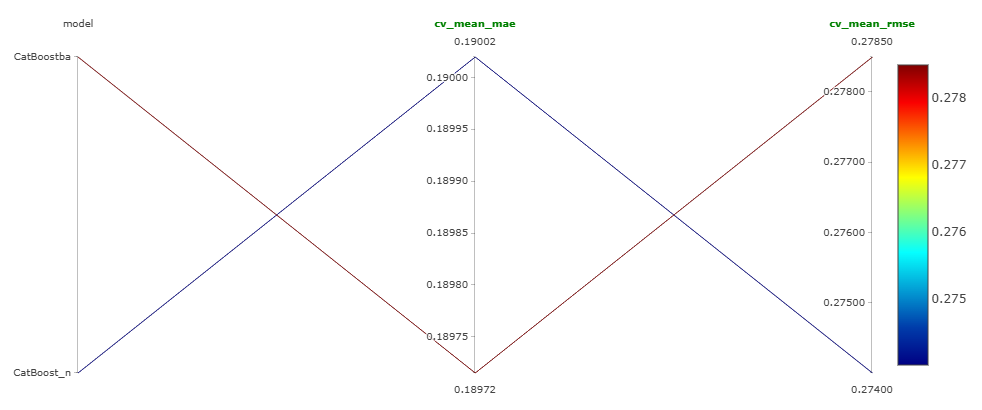

There is no significant drop in model performace when we drop the luminosity columns, instead we also get a better RMSE score

In [11]:
test_results = {}

In [12]:
X_processed = X.copy()

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])
X_train, X_test, y_train, y_test = train_test_split(X, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**params))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

y_test_orig = np.expm1(y_test)  
y_pred_orig = np.expm1(y_pred)  


mse = mean_squared_error(y_test_orig, y_pred_orig)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
print("MAE:", mae)

test_results['model 1'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig
}

print("Model saved with MLflow")

MSE: 136969057618.34453
RMSE: 370093.3093401508
MAE: 127580.66391647611
Model saved with MLflow


In [13]:
X_processed = X.drop(columns=luminosity)

binary_cat_cols = [
    col for col in X_processed.columns
    if X_processed[col].nunique() == 2
]
multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_log, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**params))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

y_test_orig = np.expm1(y_test)  
y_pred_orig = np.expm1(y_pred)  


mse = mean_squared_error(y_test_orig, y_pred_orig)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
print("MAE:", mae)

test_results['model 2'] = {
    'y_test': y_test_orig,
    'y_pred': y_pred_orig
}

print("Model saved with MLflow")

MSE: 136914679740.58409
RMSE: 370019.8369555125
MAE: 125118.51874401803
Model saved with MLflow


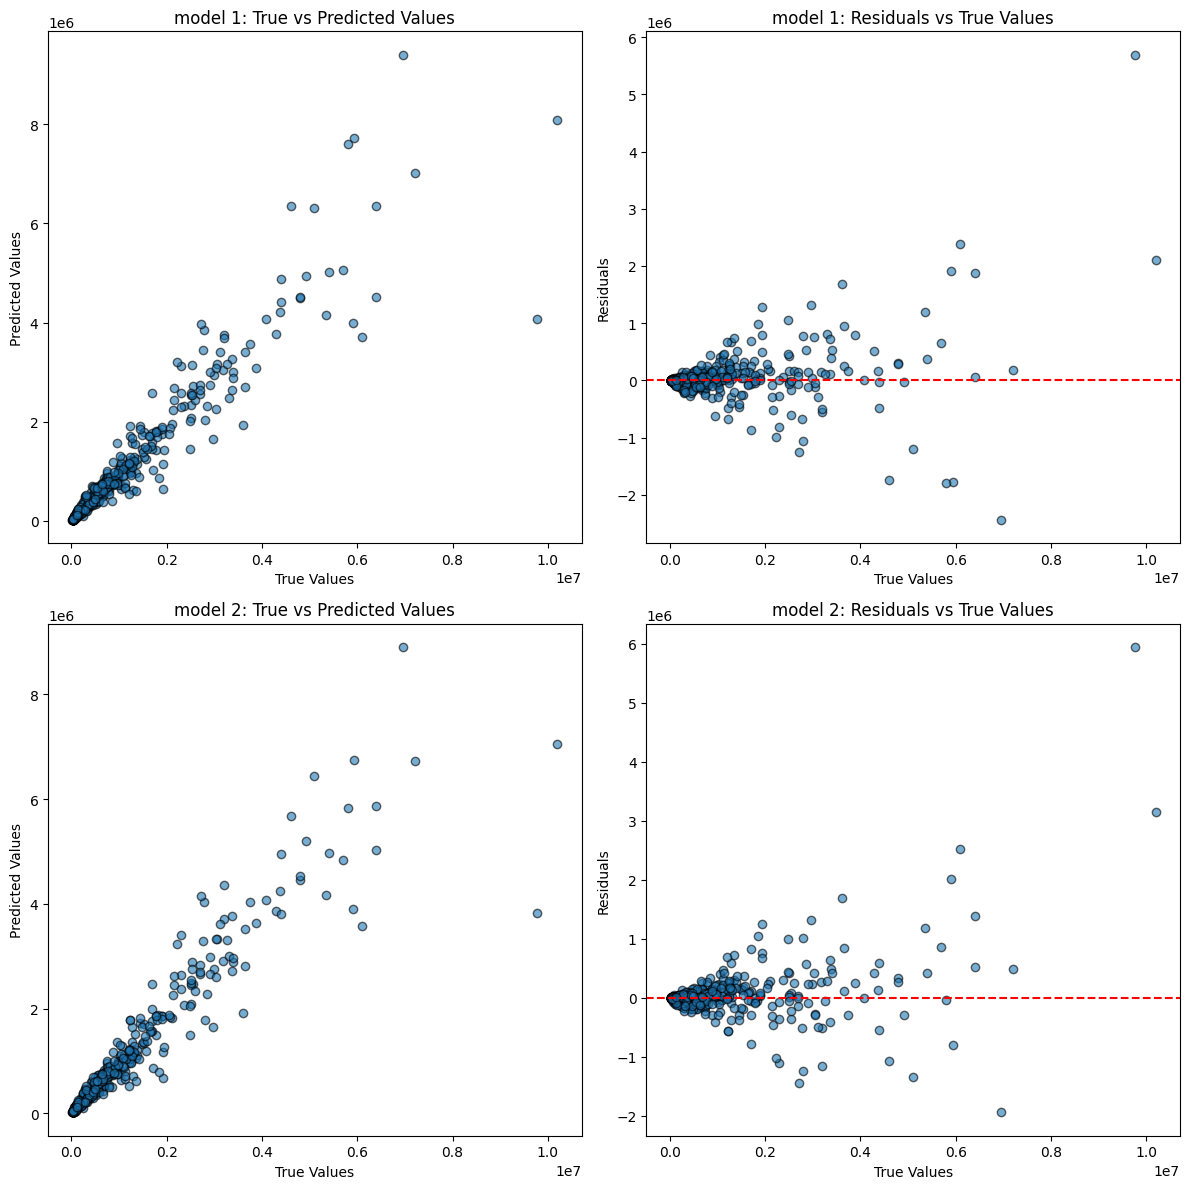

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, model in enumerate(test_results.keys()):
    ytest = test_results[model]['y_test'].values
    ypred = test_results[model]['y_pred']
    
    residuals = ytest - ypred

    ax1 = axes[i, 0]
    ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
    ax1.set_xlabel("True Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"{model}: True vs Predicted Values")

    ax2 = axes[i, 1]
    ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel("True Values")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()


Even after trying many models and hyperparamters, we find that:
1. The RMSE is higher than MAE because there are bigger errors on the higher price scale and RMSE penalizes that while MAE treats all errors as equal.
2. We don't need luminosity features

In [25]:
preprocessor = pipeline.named_steps['preprocessor']
feature_names = (
    numerical_cols + 
    binary_cat_cols + 
    list(preprocessor.named_transformers_['cat_encoder'].get_feature_names_out(multi_cat_cols))
)

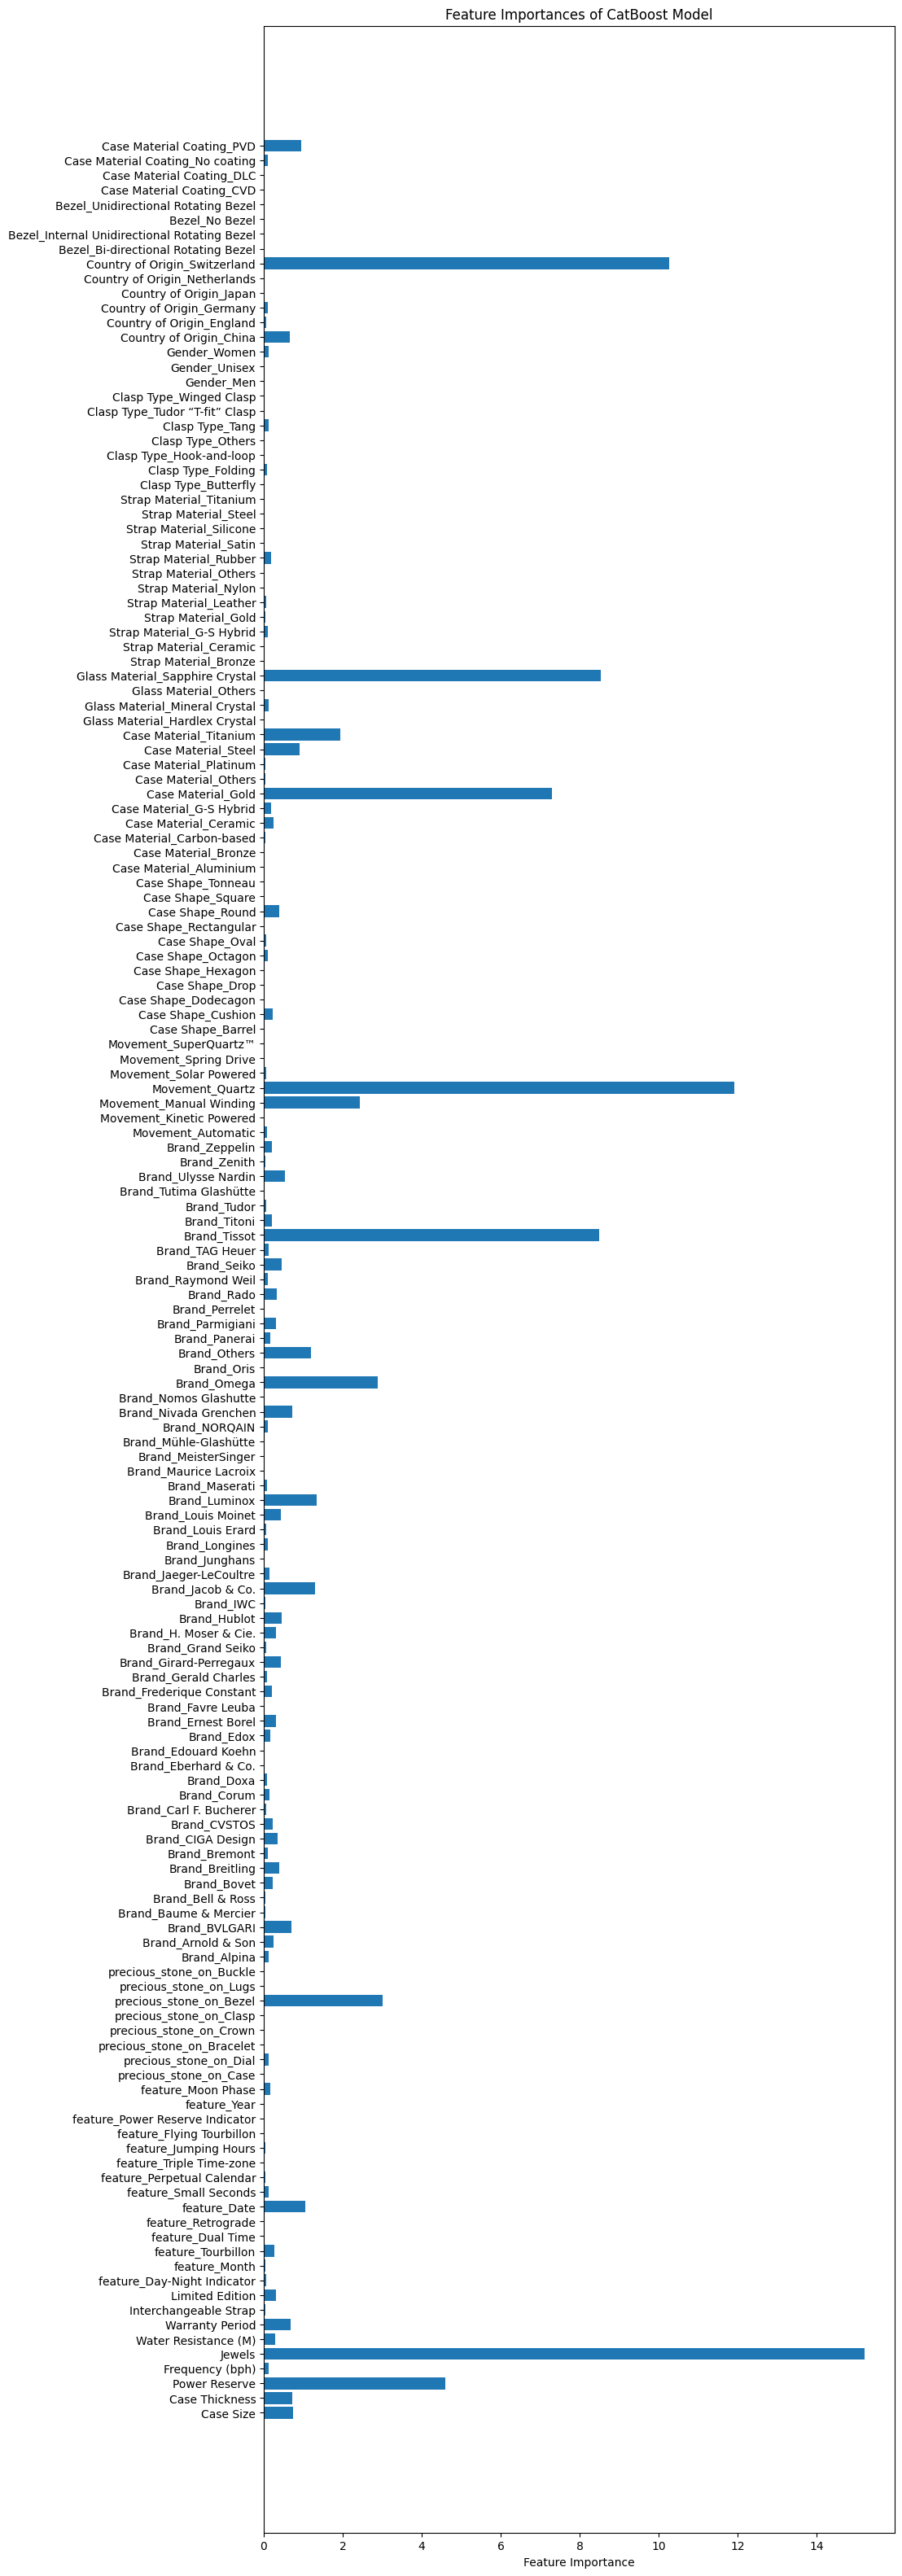

In [30]:
feature_importances = pipeline['regressor'].get_feature_importance()
plt.figure(figsize=(10, 40))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances of CatBoost Model')
plt.show()


We see some features not being very important, Let's see if we can remove them

In [43]:
features_to_remove = ['feature_Power Reserve Indicator', 'precious_stone_on_Case', 'precious_stone_on_Crown', 'precious_stone_on_Clasp', 'precious_stone_on_Bracelet', 'precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Dual Time', 'feature_Flying Tourbillon', 'feature_Year', 'Bezel']

In [44]:
import itertools

In [45]:
mlflow.set_experiment("Feature Removal")

<Experiment: artifact_location='mlflow-artifacts:/451000193621501641', creation_time=1733227901291, experiment_id='451000193621501641', last_update_time=1733227901291, lifecycle_stage='active', name='Feature Removal', tags={}>

In [46]:
def run_feature_removal_experiment(X, Y_log, features_to_remove, params):
    X_full = X.copy()
    
    experiment_strategies = [
        [],
        
        features_to_remove,
        
        *[list(combo) for r in range(1, min(len(features_to_remove), 4))
          for combo in itertools.combinations(features_to_remove, r)]
    ]
    
    results = []
    
    for removed_features in experiment_strategies:
        with mlflow.start_run(nested=True):
            X_processed = X_full.drop(columns=luminosity+removed_features)
            
            binary_cat_cols = [
                col for col in X_processed.columns
                if X_processed[col].nunique() == 2
            ]
            
            multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns
            
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num_scaler', StandardScaler(), numerical_cols),
                    ('binary_cols', 'passthrough', binary_cat_cols),
                    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
                ])
            
            final_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('regressor', CatBoostRegressor(**params))
            ])
            
            cv_results = cross_validate(
                final_pipeline, X_processed, Y_log, 
                scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                cv=5, return_train_score=True
            )
            
            mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
            mean_rmse = np.sqrt(mean_mse)
            mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
            
            mlflow.log_param('removed_features', str(removed_features))
            mlflow.log_metric("cv_mean_mse", mean_mse)
            mlflow.log_metric("cv_mean_rmse", mean_rmse)
            mlflow.log_metric("cv_mean_mae", mean_mae)
            
            results.append({
                'removed_features': removed_features,
                'mean_mse': mean_mse,
                'mean_rmse': mean_rmse,
                'mean_mae': mean_mae
            })
            
            print(f"Removed Features: {removed_features}")
            print(f"Mean MSE: {mean_mse}")
            print(f"Mean RMSE: {mean_rmse}")
            print(f"Mean MAE: {mean_mae}")
            print("-" * 50)
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('mean_rmse')
    
    return results_df

In [47]:
results = run_feature_removal_experiment(
        X, Y_log, features_to_remove, params)

Removed Features: []
Mean MSE: 0.07507735740197374
Mean RMSE: 0.27400247699970476
Mean MAE: 0.19001965002314544
--------------------------------------------------
🏃 View run angry-crab-512 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/fc21e2454b054918ad447686b96d89ee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Case', 'precious_stone_on_Crown', 'precious_stone_on_Clasp', 'precious_stone_on_Bracelet', 'precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Dual Time', 'feature_Flying Tourbillon', 'feature_Year', 'Bezel']
Mean MSE: 0.08047215160049472
Mean RMSE: 0.2836761385814724
Mean MAE: 0.19406903653375793
--------------------------------------------------
🏃 View run whimsical-duck-267 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/a3746a9dc16647bda7de0e7fe2b10e04
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4510001936215016

Removed Features: ['feature_Power Reserve Indicator', 'feature_Flying Tourbillon']
Mean MSE: 0.07750393642590243
Mean RMSE: 0.2783952880813582
Mean MAE: 0.19140322422799802
--------------------------------------------------
🏃 View run respected-turtle-234 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/115bddedf5044a2e9cdf76076c4474c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'feature_Year']
Mean MSE: 0.07809582326479783
Mean RMSE: 0.2794562993829229
Mean MAE: 0.19150467754417216
--------------------------------------------------
🏃 View run bemused-smelt-42 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/f13abbb09f0b42d3b4b8c7aefc4c857c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'Bezel']
Mean MSE: 0.07740936668662876
Mean RMSE: 0.2782253882855207
Mean MAE: 0.19222482271423072
----

Removed Features: ['precious_stone_on_Clasp', 'precious_stone_on_Bracelet']
Mean MSE: 0.07840721425624506
Mean RMSE: 0.2800128823040916
Mean MAE: 0.1916967602813074
--------------------------------------------------
🏃 View run bald-crab-948 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/1df14ab4522a41f993660683940848b1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'precious_stone_on_Buckle']
Mean MSE: 0.08013800396781072
Mean RMSE: 0.2830865662086612
Mean MAE: 0.19212667940018777
--------------------------------------------------
🏃 View run efficient-shad-684 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/876a9406f4544111a2bfe7f39fc891dc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'feature_Triple Time-zone']
Mean MSE: 0.07843987087182144
Mean RMSE: 0.2800711889356373
Mean MAE: 0.19228105686067534
--

Removed Features: ['feature_Triple Time-zone', 'feature_Year']
Mean MSE: 0.07972934928143581
Mean RMSE: 0.2823638597296683
Mean MAE: 0.19265529797309813
--------------------------------------------------
🏃 View run redolent-pig-326 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/73bcab6568984bdfacc668b9bf5e0e3e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Triple Time-zone', 'Bezel']
Mean MSE: 0.07715384921812055
Mean RMSE: 0.27776581722400717
Mean MAE: 0.1914026890490205
--------------------------------------------------
🏃 View run efficient-moose-738 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/2c6b3f7707be4def99b4e9569153c8ca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Dual Time', 'feature_Flying Tourbillon']
Mean MSE: 0.07954426642816335
Mean RMSE: 0.28203593109418407
Mean MAE: 0.1929698580604128
---------------------------------

Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Crown', 'feature_Triple Time-zone']
Mean MSE: 0.07829280233336378
Mean RMSE: 0.27980851011605024
Mean MAE: 0.19222720706585125
--------------------------------------------------
🏃 View run treasured-foal-867 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/c12ad1c01bc040ce883672a1b5eed486
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Crown', 'feature_Dual Time']
Mean MSE: 0.07823790323216447
Mean RMSE: 0.27971039171286516
Mean MAE: 0.19082128295170145
--------------------------------------------------
🏃 View run enthused-crow-284 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/d91b760b5c534ab3a7198a6cd15c4ffb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Crown', 'feature_Flying T

Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Buckle', 'feature_Dual Time']
Mean MSE: 0.07660400015280902
Mean RMSE: 0.2767742765374142
Mean MAE: 0.19046135307655127
--------------------------------------------------
🏃 View run useful-whale-991 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/f1d3ac84794b49a7a8e0906a9d278789
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Buckle', 'feature_Flying Tourbillon']
Mean MSE: 0.07925016108939983
Mean RMSE: 0.2815140513178691
Mean MAE: 0.19233144719860112
--------------------------------------------------
🏃 View run melodic-bear-520 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/efaff90e18c2483c9c011b5b77d6e21e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['feature_Power Reserve Indicator', 'precious_stone_on_Buckle', 'feature_Year']
Me

Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Crown', 'feature_Flying Tourbillon']
Mean MSE: 0.08004306118875434
Mean RMSE: 0.2829188243803412
Mean MAE: 0.1936126427285268
--------------------------------------------------
🏃 View run grandiose-ant-274 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/599b9c1aa6ee4c8fbf66c1f684fb1a97
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Crown', 'feature_Year']
Mean MSE: 0.08189877826194793
Mean RMSE: 0.28617962586799905
Mean MAE: 0.19322178673600135
--------------------------------------------------
🏃 View run burly-chimp-78 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/5e6c71ed688949e28123a8b898d8a8bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Crown', 'Bezel']
Mean MSE: 0.0811474740181362
Mean RMSE: 0.284

Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Buckle', 'feature_Year']
Mean MSE: 0.07939239007007595
Mean RMSE: 0.2817665524331729
Mean MAE: 0.192114247356329
--------------------------------------------------
🏃 View run flawless-gnu-211 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/434b897b31ff4bb6bf8a4d25935062d5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Case', 'precious_stone_on_Buckle', 'Bezel']
Mean MSE: 0.08154842537629153
Mean RMSE: 0.28556684922499587
Mean MAE: 0.1957670100504992
--------------------------------------------------
🏃 View run unequaled-goat-166 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/00891d8a08a9477784efb3843c373b0b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Case', 'feature_Triple Time-zone', 'feature_Dual Time']
Mean MSE: 0.08331231958238994
Mean RMSE: 0.288638

Removed Features: ['precious_stone_on_Crown', 'precious_stone_on_Bracelet', 'precious_stone_on_Buckle']
Mean MSE: 0.07909212579409317
Mean RMSE: 0.2812332231335643
Mean MAE: 0.19059294206946936
--------------------------------------------------
🏃 View run bedecked-moose-511 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/0fdcd616cf87438b80ddef67dcc8956e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Crown', 'precious_stone_on_Bracelet', 'feature_Triple Time-zone']
Mean MSE: 0.08004501957059482
Mean RMSE: 0.28292228539051995
Mean MAE: 0.19258162000130358
--------------------------------------------------
🏃 View run big-moose-528 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/cfd65f193b3a4695accd81b454f3732e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Crown', 'precious_stone_on_Bracelet', 'feature_Dual Time']
Mean MSE:

Removed Features: ['precious_stone_on_Crown', 'feature_Flying Tourbillon', 'Bezel']
Mean MSE: 0.07653137930094266
Mean RMSE: 0.27664305395390404
Mean MAE: 0.18997719809100264
--------------------------------------------------
🏃 View run invincible-bear-148 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/1a3e4e62e4b842b588f6fb9c4e1a5c34
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Crown', 'feature_Year', 'Bezel']
Mean MSE: 0.07704462940474513
Mean RMSE: 0.2775691434665336
Mean MAE: 0.19018710014738688
--------------------------------------------------
🏃 View run shivering-mare-306 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/4ca422f584434ffa82cd37f7b3646430
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'precious_stone_on_Bracelet', 'precious_stone_on_Buckle']
Mean MSE: 0.08010293181352648
Mean RMSE: 0.283024

Removed Features: ['precious_stone_on_Clasp', 'feature_Dual Time', 'Bezel']
Mean MSE: 0.07970924392815104
Mean RMSE: 0.2823282556318992
Mean MAE: 0.19286643929889552
--------------------------------------------------
🏃 View run upbeat-squirrel-280 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/61f83881d99849848c21fd2bad50550e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'feature_Flying Tourbillon', 'feature_Year']
Mean MSE: 0.0783224244343692
Mean RMSE: 0.2798614379194983
Mean MAE: 0.19245944366818038
--------------------------------------------------
🏃 View run illustrious-wasp-948 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/027523c2365247c3ad32dabf58a1f036
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Clasp', 'feature_Flying Tourbillon', 'Bezel']
Mean MSE: 0.07648877697787863
Mean RMSE: 0.27656604451356

Removed Features: ['precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Dual Time']
Mean MSE: 0.07755209994918913
Mean RMSE: 0.2784817766913827
Mean MAE: 0.1906041323886043
--------------------------------------------------
🏃 View run handsome-ant-876 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/10df7ea36f5e40fb81203f8ca898be38
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Flying Tourbillon']
Mean MSE: 0.07447329067903566
Mean RMSE: 0.2728979492026931
Mean MAE: 0.18725545142496577
--------------------------------------------------
🏃 View run clumsy-zebra-66 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/3d761425f77a4c14b2c56e3215962fc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641
Removed Features: ['precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Year']
Mean MSE: 0.0798191514882

After experimentation, we found that followinf columns can be dropped

In [55]:
features_to_remove = ['precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Flying Tourbillon']

In [57]:
with mlflow.start_run(nested=True):
    X_processed = X.drop(columns=luminosity+features_to_remove)

    binary_cat_cols = [
        col for col in X_processed.columns
        if X_processed[col].nunique() == 2
    ]

    multi_cat_cols = X_processed.drop(columns=binary_cat_cols + numerical_cols).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), numerical_cols),
            ('binary_cols', 'passthrough', binary_cat_cols),
            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
        ])

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(**params))
    ])

    cv_results = cross_validate(
        final_pipeline, X_processed, Y_log, 
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
        cv=5, return_train_score=True
    )

    mean_mse = -cv_results['test_neg_mean_squared_error'].mean()
    mean_rmse = np.sqrt(mean_mse)
    mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()

    mlflow.log_param('removed_features', str(features_to_remove))
    mlflow.log_metric("cv_mean_mse", mean_mse)
    mlflow.log_metric("cv_mean_rmse", mean_rmse)
    mlflow.log_metric("cv_mean_mae", mean_mae)

    print(f"Removed Features: {features_to_remove}")
    print(f"Mean MSE: {mean_mse}")
    print(f"Mean RMSE: {mean_rmse}")
    print(f"Mean MAE: {mean_mae}")
    print("-" * 50)

Removed Features: ['precious_stone_on_Crown', 'feature_Triple Time-zone', 'feature_Year']
Mean MSE: 0.07463568721929088
Mean RMSE: 0.27319532796021767
Mean MAE: 0.18751552907248345
--------------------------------------------------
🏃 View run polite-colt-143 at: http://127.0.0.1:5000/#/experiments/451000193621501641/runs/2c95ccb911484b018e0a4a2ed76eed9d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/451000193621501641


## Final Model

In [59]:
params = {'iterations': 1500,
         'learning_rate': 0.21851510473670352,
         'depth': 4,
         'l2_leaf_reg': 8,
         'rsm': 0.8488982802701295,
         'random_strength': 2.138020781242421e-05,
         'bagging_temperature': 0.00060825280116421,
         'border_count': 8,
         'verbose': 0,
         'loss_function': 'RMSE'}

In [77]:
X = df.drop(['price','precious_stone_on_Buckle', 'feature_Triple Time-zone', 'feature_Flying Tourbillon'], axis=1)
Y = df['price']
Y_log = np.log1p(Y)

numerical_cols = ['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']
categorical_cols = X.drop(columns=['Case Size', 'Case Thickness', 'Power Reserve', 'Frequency (bph)', 'Jewels', 'Water Resistance (M)', 'Warranty Period']).columns.tolist()

features = []
stones = []
luminosity = []
regular_col = []

for col in df.columns:
    if 'feature' in col:
        features.append(col)
    elif 'luminosity' in col:
        luminosity.append(col)
    elif 'precious_stone' in col:
        stones.append(col)
    else:
        regular_col.append(col)

In [78]:
X = X.drop(columns=luminosity)

binary_cat_cols = [
    col for col in X.columns
    if X[col].nunique() == 2
]

multi_cat_cols = X.drop(columns=binary_cat_cols + numerical_cols).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_cols),
        ('binary_cols', 'passthrough', binary_cat_cols),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), multi_cat_cols)
    ])

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**params))
])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_log, test_size=0.2, random_state=42)

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

y_test_orig = np.expm1(y_test)  
y_pred_orig = np.expm1(y_pred)  

mse = mean_squared_error(y_test_orig, y_pred_orig)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
print("MAE:", mae)

MSE: 153225952240.82346
RMSE: 391440.8668506949
MAE: 129557.94664165458
MSE: 26276961938.654854
RMSE: 162101.70245452345
MAE: 60566.84462918517


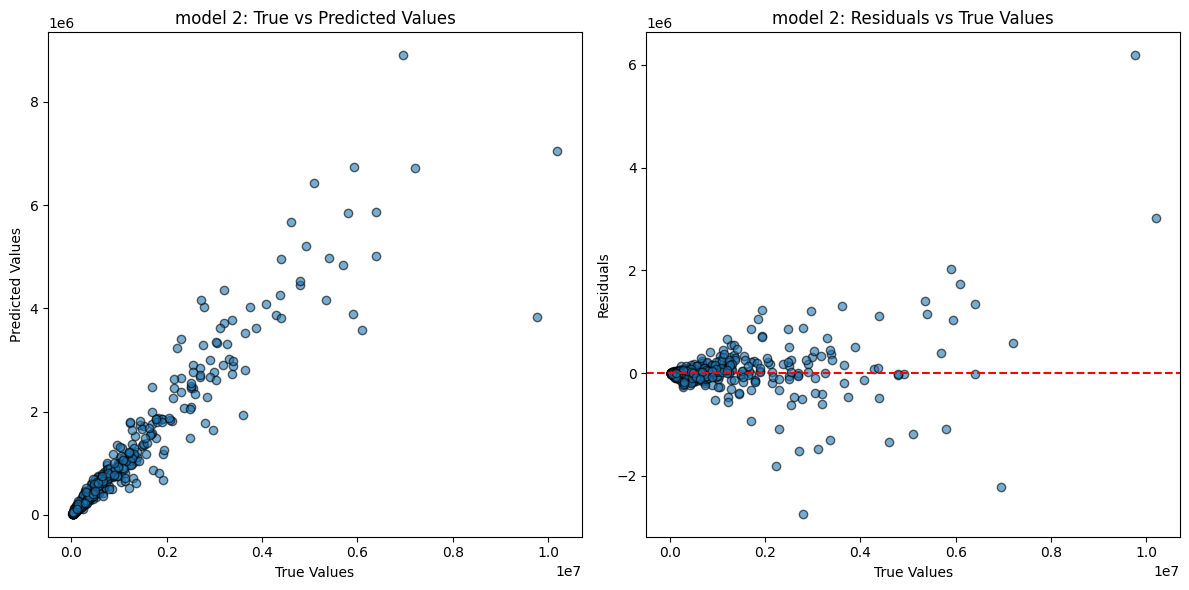

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

residuals = y_test_orig - y_pred_orig

ax1 = axes[0]
ax1.scatter(ytest, ypred, alpha=0.6, edgecolor='k')
ax1.set_xlabel("True Values")
ax1.set_ylabel("Predicted Values")
ax1.set_title(f"{model}: True vs Predicted Values")

ax2 = axes[1]
ax2.scatter(ytest, residuals, alpha=0.6, edgecolor='k')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel("True Values")
ax2.set_ylabel("Residuals")
ax2.set_title(f"{model}: Residuals vs True Values")

plt.tight_layout()
plt.show()

In [121]:
columns = X.columns
inputs = X.iloc[3465].values.tolist()

In [122]:
new_data = pd.DataFrame([inputs], columns=columns)
prediction = final_pipeline.predict(new_data)

print("Prediction:", np.expm1(prediction))

Prediction: [112230.76778964]


In [123]:
Y.iloc[3465]

100500

In [125]:
from sklearn.metrics import r2_score
r2_score(y_test_orig, y_pred_orig)

0.8945272546491063